In [12]:
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import imgaug.augmenters as iaa
import imgaug as ia
import imageio

# **Question 2**

These are helper functions, to find boxes and computing IOUs, and a class object for proposals:

In [6]:
class Proposal:
    def __init__(self, proposal, box, IoU):
        self.proposal = proposal
        self.box = box
        self.IoU = IoU

def find_box(points):
    bot_left_x = min(point[0] for point in points)
    bot_left_y = min(point[1] for point in points)
    top_right_x = max(point[0] for point in points)
    top_right_y = max(point[1] for point in points)

    return [(bot_left_x, bot_left_y), (top_right_x, top_right_y)]

def calculate_IoU(box1, box2):
    if box1[0][1] >= box2[1][1] or box1[1][1] <= box2[0][1]:
        return 0
    if box1[1][0] <= box2[0][0] or box2[1][0] <= box1[0][0]:
        return 0
   
    x_max = max(box1[0][0], box2[0][0])
    y_max = max(box1[0][1], box2[0][1])
    x_min = min(box1[1][0], box2[1][0])
    y_min = min(box1[1][1], box2[1][1])
    box1_area = (box1[1][0] - box1[0][0] + 1) * (box1[1][1] - box1[0][1] + 1)
    box2_area = (box2[1][0] - box2[0][0] + 1) * (box2[1][1] - box2[0][1] + 1)

    over_lap = max(0, x_min - x_max + 1) * max(0, y_min - y_max + 1)
    union = box1_area + box2_area - over_lap

    return over_lap / union

Load the image and add the json content as lines to it:

In [7]:
img = cv2.imread("Melli.jpg")

faces_points = []
with open("Melli.json") as meli_jason:
    json_data = json.load(meli_jason)
    for shapes in json_data["shapes"]:
        faces_points.append(shapes["points"])

img_with_faces = img.copy()
for face in faces_points:
    face_points = np.array(face, np.int32)
    img_with_faces = cv2.polylines(img_with_faces, [face_points], True, (0,0,255),2)
    face = face_points

Here we find the boxes and draw a rectangle for each of the faces:

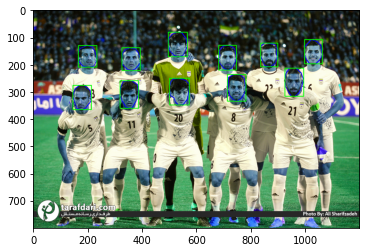

In [8]:
face_boxes = []
img_with_faces_boxes = img_with_faces.copy()
for face in faces_points:
    face_box = np.array(find_box(face), np.int32)
    img_with_faces_boxes = cv2.rectangle(img_with_faces_boxes, face_box[0], face_box[1], (0,255,0),2)
    face_boxes.append(face_box)
plt.imshow(img_with_faces_boxes)

Now we run the algorithm, you can see the boxes finded with face label at the end of this cell. We should find the hyper parameters step_size, threshold for face and threshold for background, window_size.

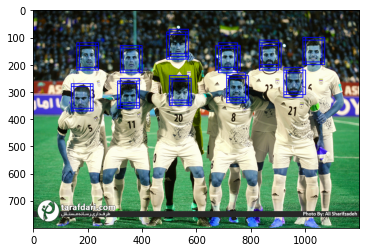

In [9]:
window_size = (70, 90)
step_size = 10
proposals = []

for x in range(0, img.shape[1] - window_size[0] , step_size):
    for y in range(0, img.shape[0] - window_size[1], step_size):
        current_box = [[x, y], [x + window_size[0], y + window_size[1]]]
        has_face = False
        for face_box in face_boxes:
            IoU = calculate_IoU(face_box, current_box)
            if(IoU >= 0.7):
                proposals.append(Proposal("face", current_box, IoU))
                has_face = True
                break
            elif(IoU >= 0.05):
                has_face = True
        if(not has_face):
                proposals.append(Proposal("background", current_box, "less than 0.07"))

detected_faces_img = img.copy()
for p in proposals:
    if (p.proposal == "face"):
        detected_faces_img = cv2.rectangle(detected_faces_img, p.box[0], p.box[1], (0,0,255),2)

plt.imshow(detected_faces_img)   

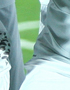

Class: background 



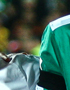

Class: background 



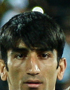

Class: face 



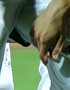

Class: background 



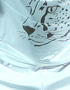

Class: background 



In [17]:
image_list = []

for i in range(5):
    random_proposal = random.choices(proposals)
    [x1, y1] = random_proposal[0].box[0]
    [x2, y2] = random_proposal[0].box[1]
    window = img[y1:y2, x1:x2, :]
    cv2_imshow(window)
    print("Class: " + random_proposal[0].proposal, '\n')

# **Q3**

In [18]:
image = img.copy()

bbs = []
bbs.append(ia.BoundingBox(x1=face_boxes[0][0][0], y1=face_boxes[0][0][1], x2=face_boxes[0][1][0], y2=face_boxes[0][1][1]))

seq = iaa.Sequential([iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Sometimes(0.1, iaa.HistogramEqualization()),
    iaa.Sometimes(0.2, iaa.LinearContrast((0.5, 2.0), per_channel=0.5)),
    iaa.Sometimes(0.2, iaa.MultiplyHue((0.5, 1.5))),
  ], random_order=True)

images_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

Here is a sample with a proposal rectangle:

before augmenting:


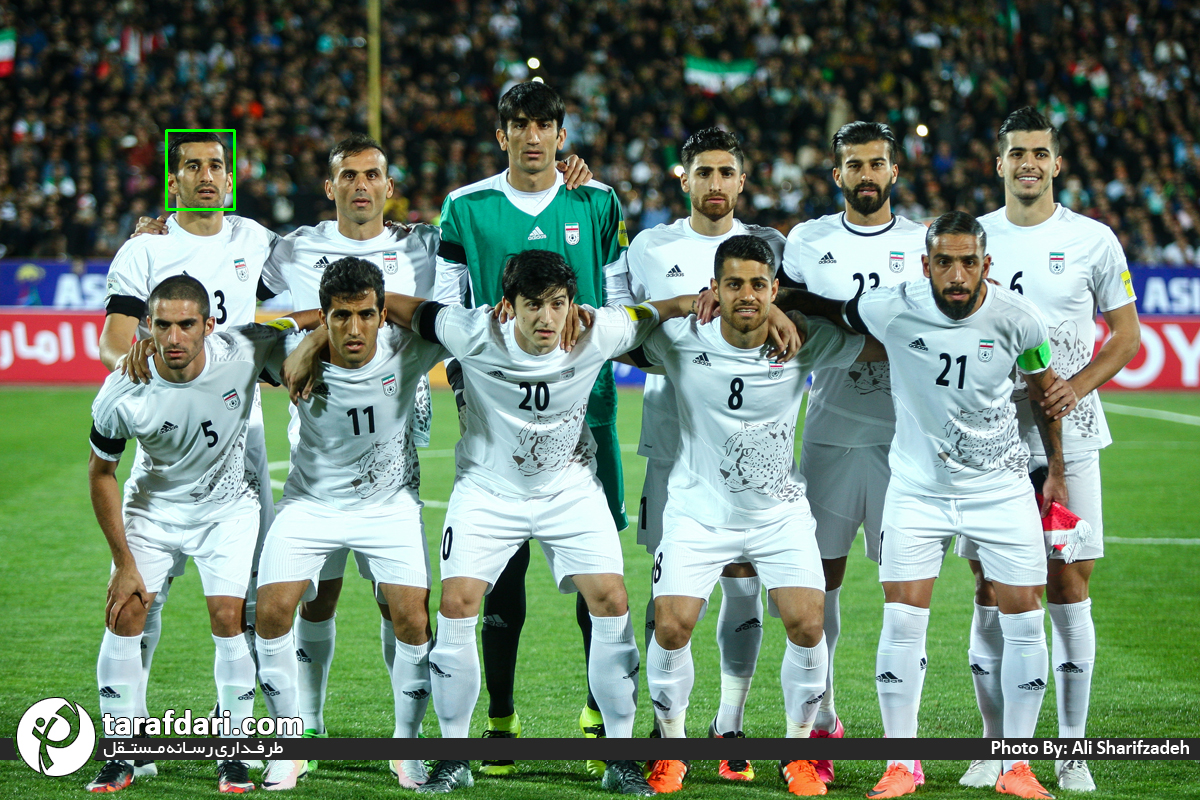


 after augmenting:


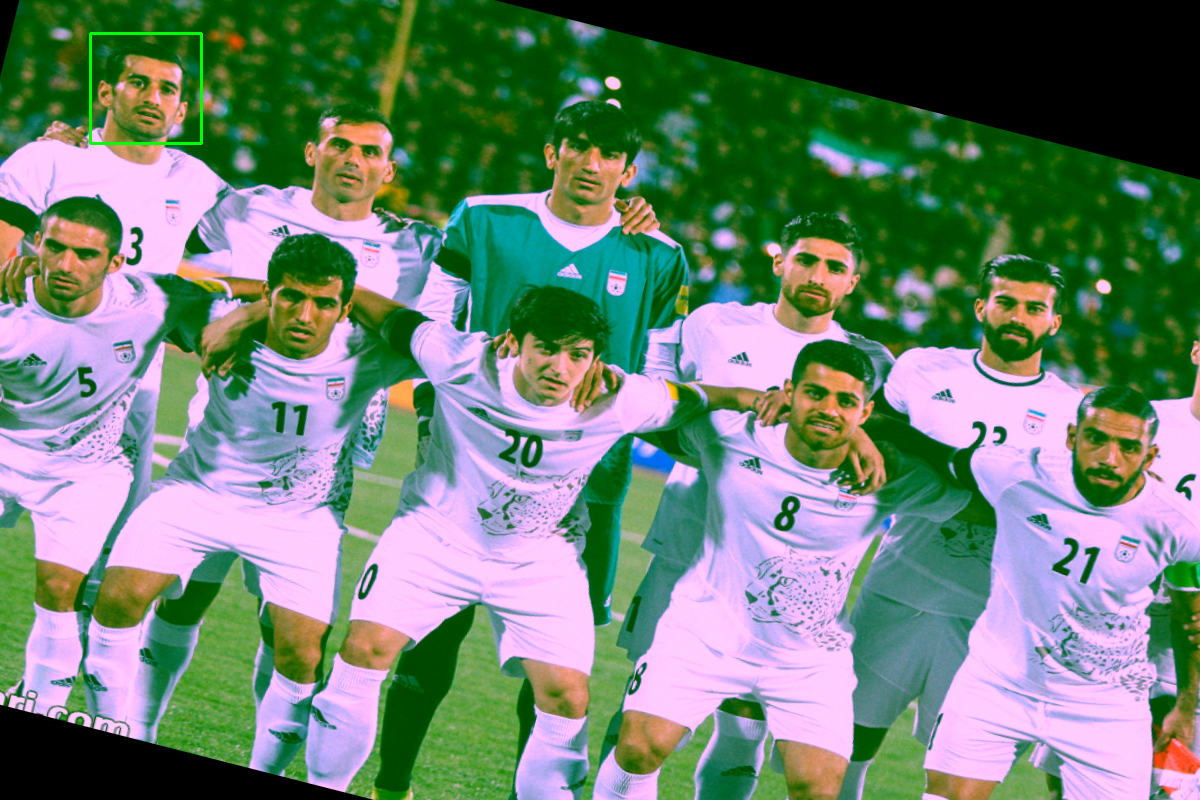

In [19]:
tmp = image.copy()
top_left = (int(bbs[0].x1), int(bbs[0].y1))
bot_right = (int(bbs[0].x2), int(bbs[0].y2))
tmp = cv2.rectangle(tmp, top_left, bot_right, (0,255,0),2)
print('before augmenting:')
cv2_imshow(tmp)

tmp = images_aug.copy()
top_left = (int(bbs_aug[0].x1), int(bbs_aug[0].y1))
bot_right = (int(bbs_aug[0].x2), int(bbs_aug[0].y2))
tmp = cv2.rectangle(tmp, top_left, bot_right, (0,255,0),2)
print('\n', 'after augmenting:')
cv2_imshow(tmp)